In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

In [2]:
# load the data
data = pd.read_csv('../data/classification_df.csv')

data

,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,...,pex_head_neck_not_present,pex_cardio_abnormal,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_abnormal,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present,dropout
0,0.0,8.0,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,...,0,0,1,0,0,0,1,0,0,1.0
1,0.0,8.0,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,...,0,0,1,0,0,1,0,0,0,1.0
2,30.0,0.0,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,...,0,0,1,0,0,1,0,0,0,1.0
3,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,...,0,0,1,0,0,0,1,0,0,1.0
4,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,...,1,0,0,0,1,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,110.0,0.0,270.0,0.0,250.0,0.0,300.0,0.0,360.0,0.0,...,0,0,1,0,0,1,0,0,0,0.0
1913,0.0,8.0,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,...,0,0,1,0,0,1,0,0,0,1.0
1914,0.0,8.0,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,...,0,1,0,0,0,0,1,0,0,0.0
1915,0.0,8.0,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,...,1,0,0,0,1,0,0,0,1,0.0


## Review Num Data

In [3]:
# in this cell we will create a number of dataframes that will merge into dataset for ML

# first we will group numeric and cat columns that are numeric

# create rsa df, including cols for baseline assessment plus 4 weeks of treatment
rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# create df for meds df, including cols for baseline assessment plus 4 weeks of treatment
meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

# create df for tests df, including cols for baseline assessment plus 4 weeks of treatment
tests = data[[col for col in data.columns if 'test' in col]].iloc[:, :45]

# create df for survey df, including cols for baseline assessment plus 4 weeks of treatment
# survey = data[[col for col in data.columns if 'survey' in col]].iloc[:, :20]

# extract demographic columns that are in binary format
# dem_num  = data[[col for col in data.columns if col.startswith('dem_') and col not in ['dem_gender','dem_ethnicity']]]

# concat num features into num_df
num_df = pd.concat([rsa, meds, tests], axis=1)

num_df

,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,...,test_Opiate300_3,test_Propoxyphene_4,test_Amphetamines_4,test_Cannabinoids_4,test_Benzodiazepines_4,test_MMethadone_4,test_Oxycodone_4,test_Cocaine_4,test_Methamphetamine_4,test_Opiate300_4
0,0.0,8.0,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,8.0,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,30.0,0.0,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,110.0,0.0,270.0,0.0,250.0,0.0,300.0,0.0,360.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1913,0.0,8.0,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,0.0,8.0,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1915,0.0,8.0,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Review Cat Data

In [4]:
# next we will group the cat columns with text strings and one hot encode them

# create df for demographics
#dem_cat = data[[col for col in data.columns if col.startswith('dem_') 
#              and col in 'dem_gender' or 'dem_ethnicity' in col]]

# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]

# create df for medical history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]

# create df for physical exam
pex = data[[col for col in data.columns if col.startswith('pex_')]]

# concat cat features into cat_df
cat_df = pd.concat([dsm, mdh, pex], axis=1)

# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, dtype=int)

cat_df



,dsm_cannabis_abuse,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_evaluated,dsm_cannabis_not_present,dsm_cocaine_abuse,dsm_cocaine_dependence,dsm_cocaine_no_diagnosis,dsm_cocaine_not_evaluated,dsm_cocaine_not_present,...,pex_head_neck_not_evaluated,pex_head_neck_not_present,pex_cardio_abnormal,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_abnormal,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1913,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1914,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1915,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


## Assign Target Variable and Combine

In [6]:
# ceate variable for target, which is the negative test rate
#ntr = data['NTR']
dropout = data['dropout']
#responder = data['responder']
 
# merge df num, cat and ntr
classification_df = pd.concat([num_df, cat_df, dropout], axis=1)

classification_df.shape

(1917, 187)

## Classification Workflow

In [7]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np



# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(classification_df,
                      target='dropout',
                      train_size=train,                        test_size=test,
                      valid_size=validation)


gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
	'subsample': [0.3, 0.5, 0.9],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='roc_auc', cv=4, verbose=1, return_train_score=True)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'objective': 'binary:logistic', 'subsample': 0.3}
Highest ROC AUC found:  0.8892035550283036


In [8]:
# refit the model with the best params
best_params = grid_auc.best_params_
best_gbm = xgb.XGBClassifier(**best_params)
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

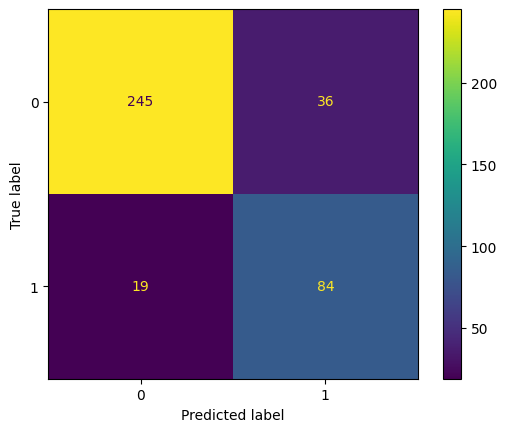

In [9]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

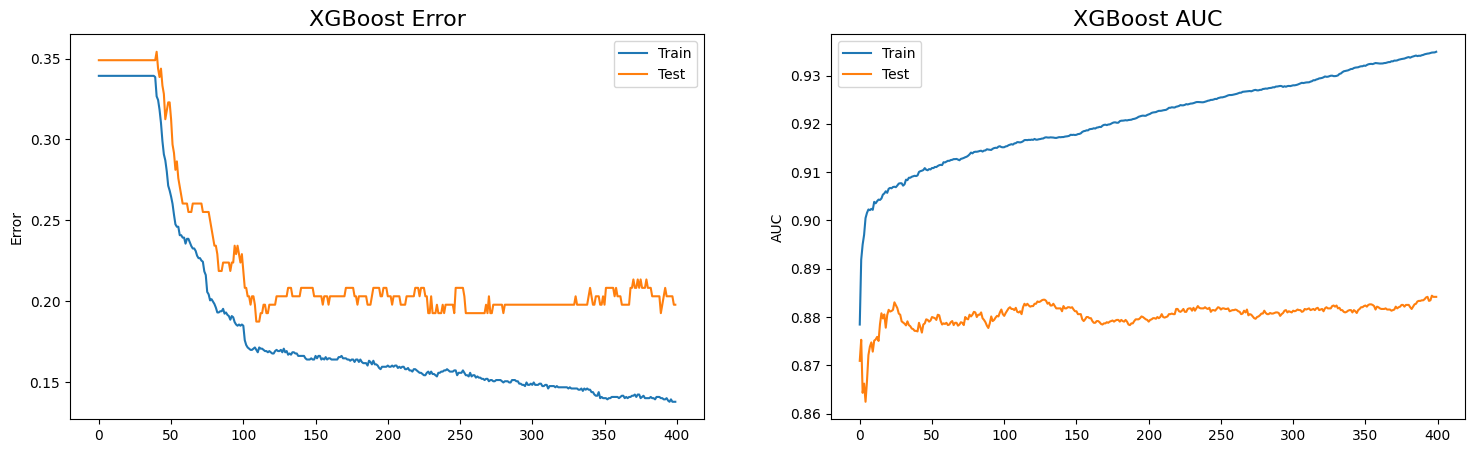

In [10]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [11]:
# Print the classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

# print accuracy for train, val and test
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))


Train Accuracy:  0.8620432513049963
Validation Accuracy:  0.8020833333333334
Test Accuracy:  0.8567708333333334


In [12]:
# print classification report for training
print('Train Classification Report')
print(classification_report(y_train, y_pred_train))

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       886
         1.0       0.75      0.88      0.81       455

    accuracy                           0.86      1341
   macro avg       0.84      0.87      0.85      1341
weighted avg       0.87      0.86      0.86      1341



In [13]:
# Print the classification report for test
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

Test classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       281
         1.0       0.70      0.82      0.75       103

    accuracy                           0.86       384
   macro avg       0.81      0.84      0.83       384
weighted avg       0.87      0.86      0.86       384



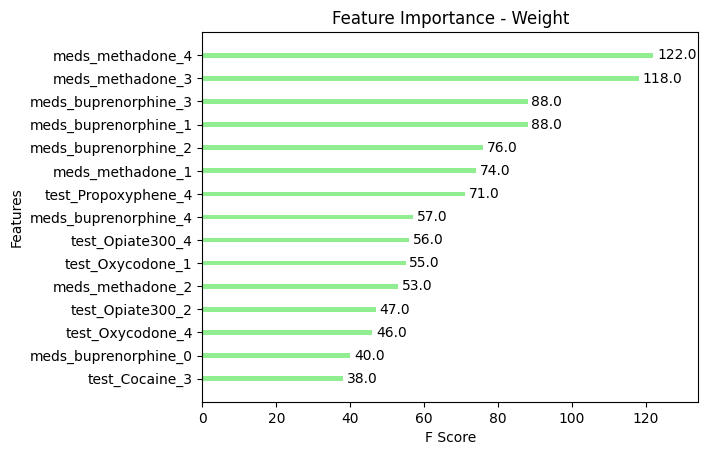

In [14]:
# plot feature importance
xgb.plot_importance(grid_auc.best_estimator_, importance_type='weight', max_num_features=15, title='Feature Importance - Weight', xlabel='F Score', ylabel='Features', color='lightgreen', grid=False)
plt.show()

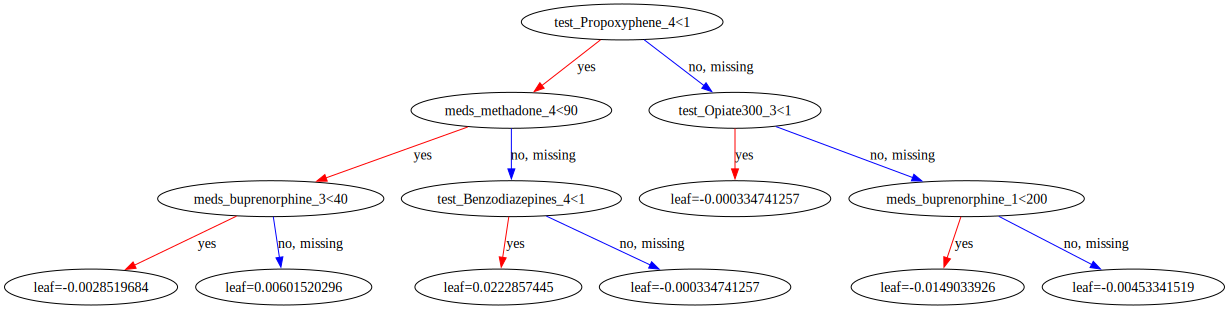

In [15]:
# Assuming 'xg_reg' is your trained XGBoost model
graph = xgb.to_graphviz(grid_auc.best_estimator_, num_trees=0)
# can I print the num trees argument?

# Display the tree plot directly in the notebook
graph